In [1]:
import sys, os
sys.path.append('/work/model/')

from head.convnext_se_unet import Encoder, DBlock, DStage, DStemNx, DStemStacked, DStemStaged, Decoder, UNet
from utils.conv_2d import adjust_padding_for_strided_output, DepthWiseSepConv
from utils.stochastic_depth_drop import create_linear_p, create_uniform_p

from dataset import CULaneSegDataset

import os
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import torchinfo
import albumentations as A
from albumentations.pytorch import ToTensorV2

import sklearn
import sklearn.metrics as metrics
import timm.scheduler

import datetime
import logging

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#########################################################
################# initialize encoder ####################
#########################################################
dp_list, dp_mode = create_linear_p([3,3,6,3], 'batch', 0.1) # creates linearly decaying stochastic depth drop probability
# dp_list, dp_mode = create_uniform_p([3,3,9,3], 'batch', 0.001) # create constant stochastic depth drop probability
    
unet_encoder = Encoder(num_blocks=[3,3,6,3], input_channels=3, stem_kersz=(4,4), stem_stride=(4,4), img_hw=[(56, 168), (28, 84), (14, 42), (7,21)], main_channels=[48, 96, 192, 384], expansion_dim=[48*4, 96*4, 192*4, 384*4],
                               kernel_sz=[(7,7),(7,7),(7,7),(7,7)], stride=[(1,1),(1,1),(1,1),(1,1)], padding=['same', 'same', 'same', 'same'], dilation=[1,1,1,1], groups=[1,1,1,1], droprate=dp_list, drop_mode=dp_mode,
                               use_se=[True, True, True, True], squeeze_ratio=16, transition_kersz=[-1, (2,2),(2,2),(2,2)], transition_stride=[-1, (2,2), (2,2), (2,2)], norm_mode='layer_norm', device='cuda')

############################################################
################# intialize decoder & head #################
############################################################

# class DStem4x(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1,
#                  dilation=1, device='cuda'):

# class DStemStacked(torch.nn.Module):
#     def __init__(self, in_channels:list, out_channels:list, kernel_size:list, stride:list, padding:list, output_padding:list, groups:list,
#                  dilation:list, device):

# class DStemStaged(torch.nn.ModuleList):
#     def __init__(self, num_blocks:list, img_hw:list, input_channels, main_channels, expansion_channels, kernel_sz, stride, padding, dilation, groups, droprate, drop_mode,
#                  use_se, squeeze_ratio, transition_kersz, transition_stride, transition_padding, transition_out_padding, device='cuda'):

# head_4x = DStemNx(in_channels=96, out_channels=128, kernel_size=(16, 24), stride=(8, 16), padding=(1,0), output_padding=(0,0), groups=1, dilation=1, device='cuda')
# head_stack = DStemStacked(in_channels=[96, 128], out_channels=[128, 256], kernel_size=[(4,4), (12,12)], stride=[(2,4), (4,4)], padding=[(1,0), (1,0)], output_padding=[(0,0), (0,0)], 
#                           groups=[1,1], dilation=[1,1], device='cuda')

# droprate, drop_mode = create_linear_p([2,2,2,2,1], dp_mode='batch', last_p=0.25)
# head_stage = DStemStaged(num_blocks=[2, 1], img_hw=[(112, 336), (224, 672)], input_channels=96, main_channels=[48, 48], expansion_channels=[48*4, 48*4],
#                          kernel_sz=[(7,7), (7,7)], stride=[(1,1), (1,1)], padding=['same', 'same'], dilation=[1, 1], groups=[1,1], 
#                          droprate=droprate[3:], drop_mode=drop_mode[3:],
#                          use_se=[True, True], squeeze_ratio=16, transition_kersz=[(7,7)]*2, transition_stride=[(2,2)]*2, transition_padding=[(3,3)]*2,
#                          transition_out_padding=[(1,1)]*2, norm_mode='layer_norm', device='cuda')

droprate, drop_mode = create_linear_p([2,2,2], dp_mode='batch', last_p=0.1)
head_4x = DStemNx(in_channels=96, out_channels=48, kernel_size=(4,4), stride=(4,4), padding=(0,0), output_padding=(0,0), groups=1, dilation=1, device='cuda')
unet_decoder = Decoder(num_blocks=[2,2,2], img_hw=[(14, 42), (28, 84), (56, 168)], main_channels=[384, 192, 96], expansion_dim=[384*4, 192*4, 96*4],
                  kernel_sz=[(7,7)]*3, stride=[(1,1)]*3, padding=['same']*3, dilation=[1]*3, groups=[1]*3, droprate=droprate, drop_mode=drop_mode,
                  use_se=[True]*3, squeeze_ratio=16, encoder_channels=[384, 192, 96, 48], transition_kersz=[(7,7)]*3, transition_stride=[(2,2)]*3,
                  transition_padding=[(3,3)]*3, transition_out_padding=[(1,1)]*3, norm_mode='layer_norm', head=head_4x, device='cuda')


############################################################
################# intialize unet model #####################
############################################################
# if num_cls==2 -> binary segmentation. to classify lane position on the road separately, 
# we need to at least make 5 masks for 4 lanes each presenting the lane position of the road. (0: background, 1: lane1, 2: lane2, 3: lane3, 4: lane4)
convnext_unet = UNet(encoder=unet_encoder, decoder=unet_decoder, num_cls=5, output_mode='probs')
torchinfo.summary(convnext_unet, (1, 3, 224, 672)) # in case of DStem4x as decoder head, parameter size is 71,424,785 (convnext tiny size, symmetric decoder design with light head)

Layer (type:depth-idx)                                  Output Shape              Param #
UNet                                                    [1, 5, 224, 672]          --
├─Encoder: 1-1                                          [1, 384, 7, 21]           --
│    └─Stem: 2-1                                        [1, 48, 56, 168]          --
│    │    └─Conv2d: 3-1                                 [1, 48, 56, 168]          2,352
│    └─ModuleList: 2-2                                  --                        --
│    │    └─Stage: 3-2                                  [1, 48, 56, 168]          2,780,793
│    │    └─Stage: 3-3                                  [1, 96, 28, 84]           1,634,994
│    │    └─Stage: 3-4                                  [1, 192, 14, 42]          3,489,480
│    │    └─Stage: 3-5                                  [1, 384, 7, 21]           4,653,000
├─Decoder: 1-2                                          [1, 48, 224, 672]         --
│    └─ModuleList: 2-3       

### Load Segmentation Label and images

In [3]:
BASE_PATH='/work/dataset/CULane'
with open(BASE_PATH+'/list/train_gt.txt', 'r') as fr:
    train_list = fr.readlines()
with open(BASE_PATH+'/list/val_gt.txt', 'r') as fr:
    val_list = fr.readlines()
with open(BASE_PATH+'/list/test.txt', 'r') as fr:
    test_list = fr.readlines()

In [4]:
print("number of train pairs: ", len(train_list))
print("number of validation pairs: ", len(val_list))
print("number of test pairs: ", len(test_list))

print()
print("total number of data: ", len(train_list) + len(val_list) + len(test_list))
print("number of trainable data: ", len(train_list)+len(val_list)) #98555 -> this is same as manually collecting trainable pairs

number of train pairs:  88880
number of validation pairs:  9675
number of test pairs:  34680

total number of data:  133235
number of trainable data:  98555


In [5]:
train_x, train_y, train_y_lane = [], [], [] # train_y_lane denotes whether lane exist or not.
val_x, val_y, val_y_lane = [], [], []
test_x = []
BASE_PATH = '/work/dataset/CULane'
for path in train_list:
    tokens = path.split(' ')
    train_x.append(BASE_PATH+tokens[0])
    train_y.append(BASE_PATH+tokens[1])
    train_y_lane.append([int(tokens[2]), int(tokens[3]), int(tokens[4]), int(tokens[5].strip())])

for path in val_list:
    tokens = path.split(' ')
    val_x.append(BASE_PATH+tokens[0])
    val_y.append(BASE_PATH+tokens[1])
    val_y_lane.append([int(tokens[2]), int(tokens[3]), int(tokens[4]), int(tokens[5].strip())])

for path in test_list:
    test_x.append(BASE_PATH+path.strip())

#### variables

**segmentation_list: segmentation annotation path list {video_folder}/{video_name}/{frame_name}**

**segmentation_img_list: source images corresponds to segmentation annotation path {video_folder}/{video_name}/{frame_name}**

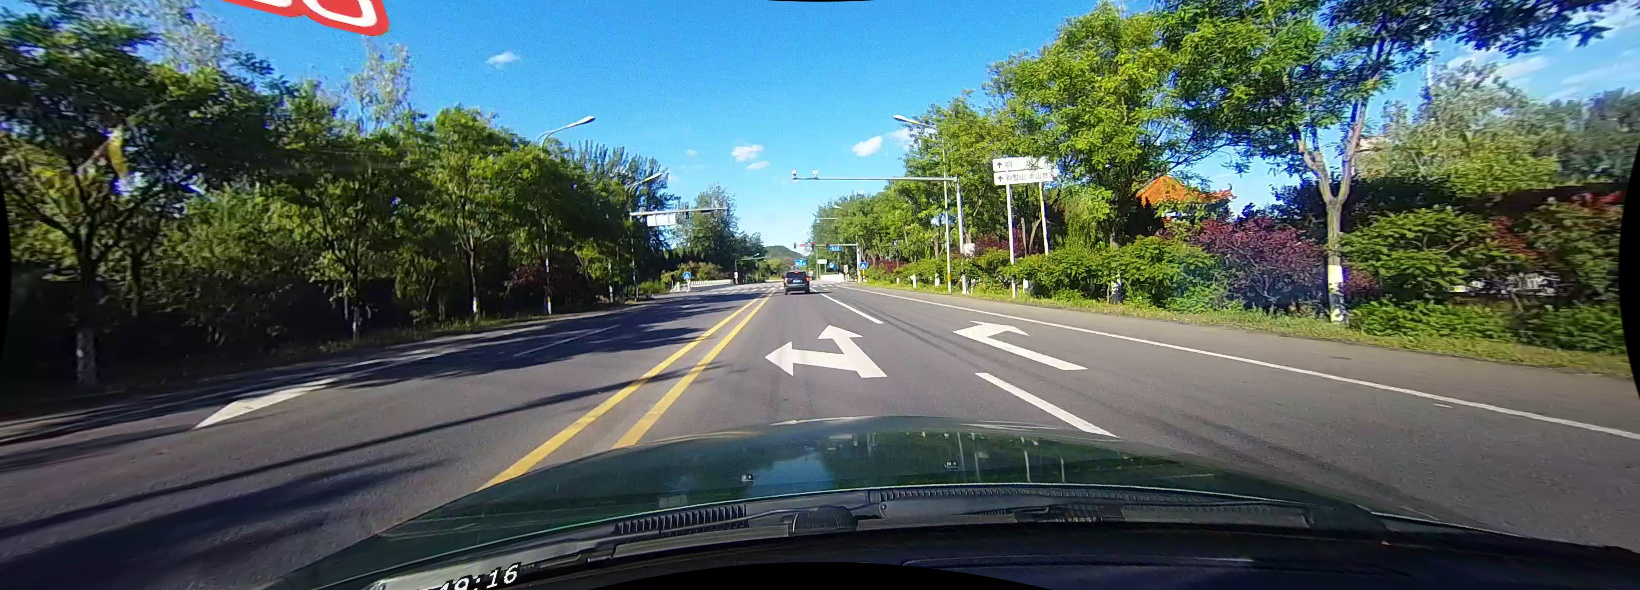

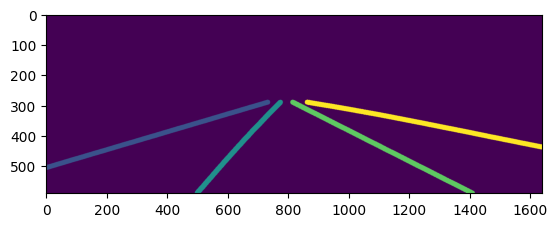

In [6]:
%matplotlib inline
ex_img = Image.open(train_x[0])
ex_img.show()
mask_img = Image.open(train_y[0])
mask_img = np.array(mask_img)
plt.imshow(mask_img)

In [7]:
%matplotlib inline
# to augment segmentation images, we need to both consider source image and segmentation mask

transforms = A.Compose([
    A.Resize(224, 672),
    A.ColorJitter(brightness=(0.6, 1.8), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=1, translate_percent=(0.05, 0.05), rotate=(-2,2), shear=(0, 0), p=0.5),
    A.MotionBlur(blur_limit=7, p=0.5),
    ToTensorV2(p=1.0),
])

transformed = transforms(image=np.array(ex_img), mask=mask_img)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

print("transformed image shape: ", transformed_image.shape)

print("example ratio between background and lanes: ", (transformed_mask!=0).sum()/(transformed_mask==0).sum())
# Image.fromarray(transformed_image).show()
# plt.imshow(transformed_mask)
# plt.close('all')


transformed image shape:  torch.Size([3, 224, 672])
example ratio between background and lanes:  tensor(0.0442)


In [8]:
# need to transform mask to onehot encoding
print("transformed mask shape: ", transformed_mask.shape)
mask_onehot = torch.nn.functional.one_hot(torch.tensor(transformed_mask).long(), num_classes=5) # in case of pass ToTensorV2
# mask_onehot = torch.nn.functional.one_hot(transformed_mask.long(), num_classes=5) # in case of applying ToTensorV2
print("mask_onehot shape: ", mask_onehot.shape)
print("mask onehot example: ", mask_onehot[150,150,:])
print("desired output format: ", mask_onehot.permute(2,0,1).shape) # (B, C, H, W)

transformed mask shape:  torch.Size([224, 672])
mask_onehot shape:  torch.Size([224, 672, 5])
mask onehot example:  tensor([1, 0, 0, 0, 0])
desired output format:  torch.Size([5, 224, 672])


/tmp/ipykernel_5662/1043222076.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_onehot = torch.nn.functional.one_hot(torch.tensor(transformed_mask).long(), num_classes=5) # in case of pass ToTensorV2


In [9]:
class CULaneSegDataset(torch.utils.data.Dataset):
    def __init__(self, segmentation_img_list, segmentation_mask_list, transforms=None, num_classes=5, is_test=False):
        self.segmentation_img_list = segmentation_img_list
        self.segmentation_mask_list = segmentation_mask_list
        self.transforms = transforms # transforms that are only related to source image
        self.is_test = is_test
        self.num_classes = num_classes # number of classes for one-hot encoding
        
        self.img_resize=None
        self.mask_resize=None
    
    def __len__(self):
        return len(self.segmentation_img_list)
    
    def __getitem__(self, idx):
        if self.is_test:
            image = Image.open(self.segmentation_img_list[idx])
            image = image.convert('RGB')
            image = np.array(image)
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed['image']
            return image
        else:
            image = Image.open(self.segmentation_img_list[idx])
            image = image.convert('RGB') # to ensure all image have 3 RGB channels format
            mask = Image.open(self.segmentation_mask_list[idx])
            image = np.array(image)
            mask = np.array(mask)
            
            if self.transforms:
                # albumentation transforms applies to both src image and segmentation mask
                transformed = self.transforms(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
            mask_onehot = torch.nn.functional.one_hot(mask.long(), num_classes=self.num_classes)
            mask_onehot = mask_onehot.permute(2,0,1) # (H,W,C) -> (C, H, W)
            return image, mask_onehot
    
train_transforms = A.Compose([
    A.Resize(224, 672),
    A.ColorJitter(brightness=(0.5, 1.5), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=1, translate_percent=(0.05, 0.05), rotate=(2,2), shear=(0, 0), p=0.5),
    A.MotionBlur(blur_limit=7, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), normalization='standard', p=1.0), # normalize images
    ToTensorV2(p=1.0) # convert to pytorch Tensor format (HWC -> CHW)
])

val_transforms = A.Compose([
    A.Resize(224, 672),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), normalization='standard', p=1.0),
    ToTensorV2(p=1.0)
])

In [10]:
train_dataset = CULaneSegDataset(train_x, train_y, transforms = train_transforms)
val_dataset = CULaneSegDataset(val_x, val_y, transforms=val_transforms)
test_dataset = CULaneSegDataset(test_x, None, transforms=val_transforms, is_test=True)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"number of iterations by batch_size {batch_size}: ", len(train_dataloader))
print(f"number of val iterations by batch_size {batch_size}: ", len(val_dataloader))
print(f"number of test iterations by batch_size {batch_size}: ", len(test_dataloader))

number of iterations by batch_size 32:  2778
number of val iterations by batch_size 32:  303
number of test iterations by batch_size 32:  1084


In [11]:
masks_0 = torch.zeros((1, 5, 256, 256))
masks_1 = torch.ones((1, 1, 256, 256))
masks_0[:,2:3, :, :] += masks_1 # (B, C, H, W)
pred_mask = torch.argmax(masks_0, dim=1)  # (B, H ,W)
print("prediction shape: ", pred_mask.shape)
label_mask = torch.zeros([1, 256, 256])
label_mask[:, 128:, 128:] += 2

intersection = (pred_mask == label_mask).sum() # 16384 pixels are correct
union = pred_mask.shape[1] * pred_mask.shape[2] + label_mask.shape[1] * label_mask.shape[2]
dice = intersection*2 / union
print("IoU: ", dice)
dice_loss = 1 - dice
print("dice loss: ", dice_loss)

masks_0[0, 0:1, :, :].shape

prediction shape:  torch.Size([1, 256, 256])
IoU:  tensor(0.2500)
dice loss:  tensor(0.7500)


torch.Size([1, 256, 256])

In [12]:
LR=0.001
LR_MIN=1e-5
EPOCHS=100
DECAY=0.5
MUL=1.0
LIMIT=100
WARMUP=5
WARMUP_INIT=0.00001
STEP_SIZE=50

class DICELoss(torch.nn.Module):
    def __init__(self, weights=None, num_cls=5):
        super(DICELoss, self).__init__()
        if weights!=None and len(weights) != num_cls:
            raise Exception("number of weights should be equal to number of classes")
        self.weights=weights # when weights are None, all classes have same weight (treated equally)
        self.num_cls = num_cls
    
    def forward(self, pred_mask, mask):
        intersection = torch.tensor(0.0, requires_grad=True)
        union = torch.tensor(0.0, requires_grad=True)
        if self.weights != None:
            for i in range(self.num_cls):
                intersection = intersection + (pred_mask[:, i, :, :] * mask[:, i, :, :]).sum() * self.weights[i]
                union = union + (torch.sum(pred_mask[:, i, :, :]) + torch.sum(mask[:, i, :, :])) * self.weights[i]
                
            dice = intersection * 2 / union
            dice_loss = 1 - dice
        else:
            intersection = (pred_mask * mask).sum()
            union = torch.sum(pred_mask) + torch.sum(mask)
            
            dice = intersection*2 / union
            dice_loss = 1 - dice
        return dice_loss

# metrics for dice coefficient calculation
def get_dice_score(pred_mask, mask):
    intersection = np.sum(pred_mask * mask)
    union = np.sum(pred_mask) + np.sum(mask)    
    dice = intersection*2 / union
    return dice

# metrics for IoU (Intersection over Union) calculation
def get_iou_score(pred_mask, mask):
    intersection = np.sum(pred_mask * mask)
    union = np.sum(pred_mask) + np.sum(mask) - intersection
    iou = intersection / union
    return iou

# metrics for Lane IoU calculation
def get_lane_score(pred_mask, mask):
    pred_mask = np.argmax(pred_mask, axis=1) # (B, H, W)
    mask = np.argmax(mask, axis=1)           # (B, H, W)
    intersection = np.sum(np.logical_and(pred_mask!=0, pred_mask==mask)) # exclude background pixels calculating IoU with mask pixels
    union = np.sum(pred_mask!=0) + np.sum(mask!=0) - intersection
    lane_iou = intersection / union
    return lane_iou
    

optimizer = torch.optim.AdamW(convnext_unet.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
# criterion = torch.nn.CrossEntropyLoss() # cross entropy loss for training
# criterion = DICELoss(weights=[0.5, 1.2, 1.2, 1.2, 1.2], num_cls=5) # weighted dice loss example
criterion = DICELoss(num_cls=4) # dice loss
scheduler = timm.scheduler.cosine_lr.CosineLRScheduler(optimizer, t_initial=STEP_SIZE, lr_min=LR_MIN, cycle_mul=MUL, cycle_decay=DECAY,
                                                    cycle_limit=LIMIT, warmup_t=WARMUP, warmup_lr_init=WARMUP_INIT)

#### Start Training and Validating

Define train and validation loop and visualize the training process

In [13]:
# create directories if not exist
def checkdir(path):
    if not os.path.exists(path):
        print("creating directories: ", path)
        os.makedirs(path)

currtime = (datetime.datetime.utcnow() + datetime.timedelta(hours=9)).strftime("%Y_%m_%d_%H%M%S") # need to plus 9 hours to utc time (ktz=utc+9)

weight_dir = '/work/checkpoints'
plot_dir = '/work/plots'
project_name = f'convnext_tiny_unet/culane/{currtime}'

save_path = weight_dir + '/' + project_name
save_plot_path = plot_dir + '/' + project_name
save_step = 10 # save model weights per 10 epochs
save_plot_step = 5 # save plots per 5 epochs

checkdir(save_path)
checkdir(save_plot_path)

# copying files for saving experiments
os.system(f'cp /work/model/backbone/convnext_se/convnext_se.py {save_path}/convnext_se.py')
os.system(f'cp /work/model/head/convnext_se_unet.py {save_path}/convnext_se_unet.py')
os.system(f'cp /work/train/CULane/segmentation/train.ipynb {save_path}/train.ipynb')


train_history = []
val_history = []

train_dice = []
val_dice = []

lr_history = []

train_num_prints = 100
val_num_prints = 10

total_train_iter = len(train_dataloader)
total_val_iter = len(val_dataloader)

print_threshold = int(total_train_iter/train_num_prints)
val_print_threshold = int(total_val_iter/val_num_prints)

start_epoch = 0
end_epoch = 100

convnext_unet = convnext_unet.to('cuda')

# checkpoint file loadings
# checkpoint_fname = ""
# load_path = save_path + '/weights' + checkpoint_fname
# checkpoint = torch.load(load_path)
# convnext_unet.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

torch.backends.cudnn.enabled=True
torch.backends.cudnn.benchmark=True

train_logger = logging.getLogger('train')
val_logger = logging.getLogger('val')

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s', datefmt="%Y-%m-%d %H:%M:%S")
train_file_handler = logging.FileHandler(save_path+'/train.log')
val_file_handler = logging.FileHandler(save_path+'/val.log')

train_file_handler.setFormatter(formatter)
val_file_handler.setFormatter(formatter)

train_logger.setLevel(logging.INFO)
val_logger.setLevel(logging.INFO)

train_logger.addHandler(train_file_handler)
val_logger.addHandler(val_file_handler)


for epoch in range(start_epoch, end_epoch): # epochs follows 0-index ordering
    convnext_unet.train()
    
    train_logger.info(f'epoch: {epoch+1} start!')
    running_loss = 0.0
    loss_container = []
    dice_container = []
    for i, batch in enumerate(train_dataloader, 1): # batch, i follows 1-index ordering
        optimizer.zero_grad()

        image, mask = batch
        image = image.to('cuda')
        mask = mask.to('cuda')
        
        prediction_mask = convnext_unet(image)
        loss = criterion(prediction_mask, mask)
        
        loss.backward() 
        optimizer.step()
        
        loss_container.append(loss.detach().item())
        dice_value = get_dice_score(prediction_mask.cpu().detach().numpy(), mask.cpu().detach().numpy())
        dice_container.append(dice_value)
        
        running_loss += loss.detach().item()
        if i % print_threshold == 0:
            print(f"training [{epoch+1}:{i:5d}/{total_train_iter}] loss: {running_loss/print_threshold:.3f} lr: {optimizer.param_groups[0]['lr']}")
            train_logger.info(f"training [{epoch+1}:{i:5d}/{total_train_iter}] loss: {running_loss/print_threshold:.3f} lr: {optimizer.param_groups[0]['lr']}")
            running_loss = 0.0
        
    loss = np.mean(loss_container)
    dice_coeff = np.mean(dice_container)
    train_history.append(loss)
    train_dice.append(dice_coeff)
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    print("="*50)
    print(f"Train Epoch: {epoch+1}, Dice Score: {dice_coeff:.3f}, Loss: {loss:.3f}, LR: {optimizer.param_groups[0]['lr']}")
    print("="*50)
    train_logger.info('='*50 + f"\nTrain Epoch: {epoch+1}, Dice Score: {dice_coeff:.3f}, Loss: {loss:.3f}, LR: {optimizer.param_groups[0]['lr']}\n" + '='*50)
    
    convnext_unet.eval()
    running_loss = 0.0
    loss_container = []
    dice_container = []
    with torch.no_grad():
        val_logger.info(f'epoch: {epoch+1} start!')
        for i, batch in enumerate(val_dataloader, 1):
            image, mask = batch
            image = image.to('cuda')
            mask = mask.to('cuda')
            
            prediction_mask = convnext_unet(image)
            loss = criterion(prediction_mask, mask)
            
            loss_container.append(loss.detach().item())
            running_loss += loss.detach().item()
            

            dice_coeff = get_dice_score(prediction_mask.cpu().detach().numpy(), mask.cpu().detach().numpy())
            dice_container.append(dice_coeff)
            
            if i % val_print_threshold == 0:
                print(f"Validation [{epoch+1}:{i:5d}/{total_val_iter}] loss: {running_loss/val_print_threshold:.3f}")
                val_logger.info(f"Validation [{epoch+1}:{i:5d}/{total_val_iter}] loss: {running_loss/val_print_threshold:.3f}")
                running_loss = 0.0
    
    loss = np.mean(loss_container)
    dice_coeff = np.mean(dice_container)
    val_history.append(loss)
    val_dice.append(dice_coeff)
    
    print("="*50)
    print(f"Val Epoch: {epoch+1}, Dice Score: {dice_coeff:.3f}, Loss: {loss:.3f}, LR: {optimizer.param_groups[0]['lr']}")
    print("="*50)
    
    val_logger.info('=' * 50 + f"\nVal Epoch: {epoch+1}, Dice Score: {dice_coeff:.3f}, Loss: {loss:.3f}, LR: {optimizer.param_groups[0]['lr']}\n" + '=' * 50)
    

    # update scheduler
    scheduler.step(epoch)
    
    checkdir(save_path+'/weights')
    if ((epoch+1) % save_step) == 0 or (epoch+1)==end_epoch:
        print("+"*50)
        print(f"Saving Model to {save_path}/weights...")
        print("+"*50)
        
        currtime = (datetime.datetime.utcnow() + datetime.timedelta(hours=9)).strftime("%Y_%m_%d_%H%M%S")
        torch.save({
            'epoch': epoch,
            'model_state_dict' : convnext_unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict(),
        }, f'{save_path}/weights/{currtime}_epoch{epoch+1}.pth') # epochs are saved as 1-index ordering (index 0 means initial state)
        
    
    if ((epoch+1) % save_plot_step) == 0 or (epoch+1)==end_epoch:
        checkdir(save_plot_path)
        checkdir(save_plot_path+'/loss')
        checkdir(save_plot_path+'/dice')
        checkdir(save_plot_path+'/lr')
        
        try:
            tick_step = 1
            # plot dice loss
            plt.figure(figsize=(12, 8))
            plt.title('Training and Validation Loss')
            plt.plot(range(len(train_history)), train_history, label='train loss')
            plt.plot(range(len(val_history)), val_history, label='val loss')
            plt.xticks(range(0, len(train_history)+1, tick_step))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'{save_plot_path}/loss/{epoch}.png')
            
            # plot dice coefficients
            plt.figure(figsize=(12, 8))
            plt.title('Training and Validation Dice Score')
            plt.plot(range(len(train_dice)), train_dice, label='train dice coeff')
            plt.plot(range(len(val_dice)), val_dice, label='val dice coeff')
            plt.xticks(range(0, len(train_dice)+1, tick_step))
            plt.xlabel('Epochs')
            plt.ylabel('Dice Score')
            plt.legend()
            plt.savefig(f'{save_plot_path}/dice/{epoch}.png')
            
            # plot lr
            plt.figure(figsize=(12, 8))
            plt.title('Learning Rate')
            plt.plot(range(len(lr_history)), lr_history, label='learning rate')
            plt.xticks(range(0, len(lr_history), tick_step))
            plt.xlabel('Epochs')
            plt.ylabel('LR')
            plt.legend()
            plt.savefig(f'{save_plot_path}/lr/{epoch}.png')
            
            # need to close all plots to save memory
            plt.close('all')
        except:
            print("[Error]: Error while saving plots.....")

creating directories:  /work/checkpoints/convnext_tiny_unet/culane/2025_02_13_181902
creating directories:  /work/plots/convnext_tiny_unet/culane/2025_02_13_181902


KeyboardInterrupt: 

### Inference

#### Iterate over test dataset, check the inference result

restore to original image, mask size to check the final inference result

In [50]:
checkpoints = torch.load('/work/checkpoints/convnext_unet_4x/culane/pretrained/2025_02_24_154811/weights/2025_02_25_100706_epoch60.pth')

# filtering weight name 'module.' on checkpoint file name (if not using torch.distributed training, 'module.' on key string need to be filtered.)
for key in list(checkpoints['model_state_dict'].keys()):
    if 'module.' in key:
        checkpoints['model_state_dict'][key.replace('module.', '')] = checkpoints['model_state_dict'][key]
        del checkpoints['model_state_dict'][key]

convnext_unet.load_state_dict(checkpoints['model_state_dict'])
convnext_unet.to('cpu')
convnext_unet = convnext_unet.eval()

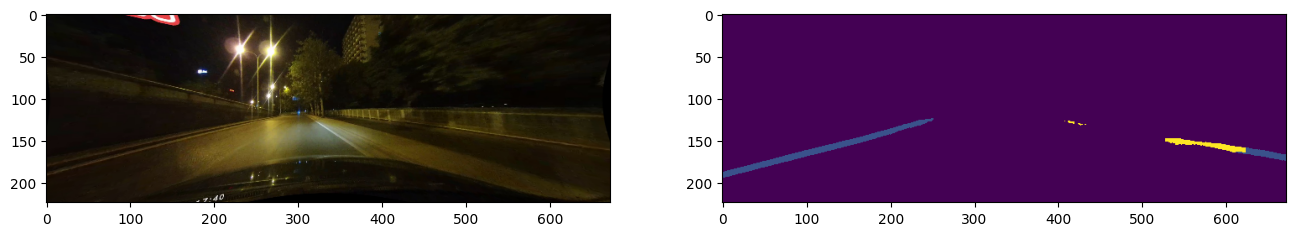

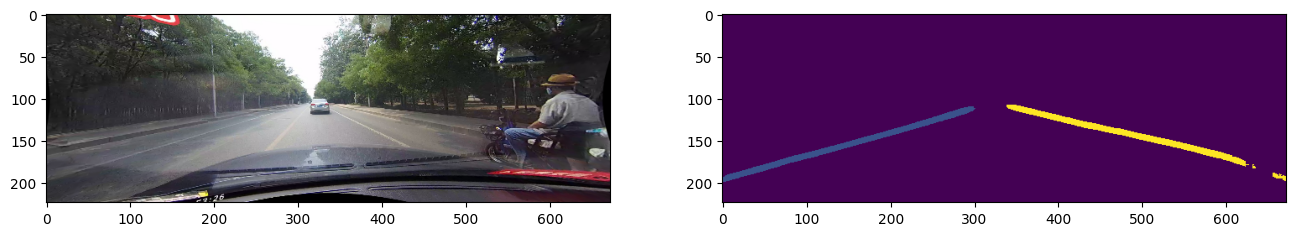

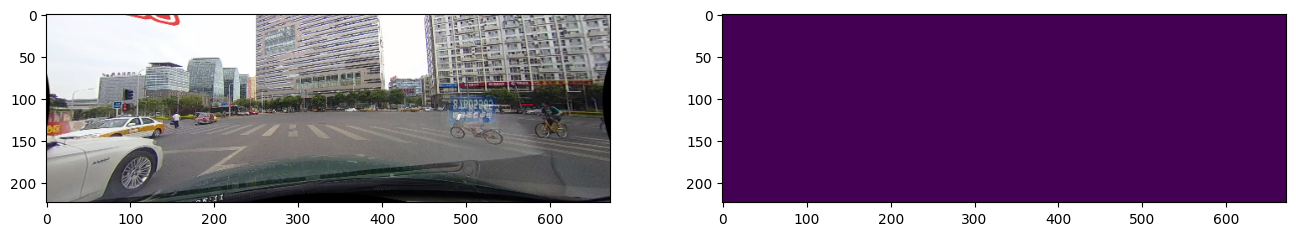

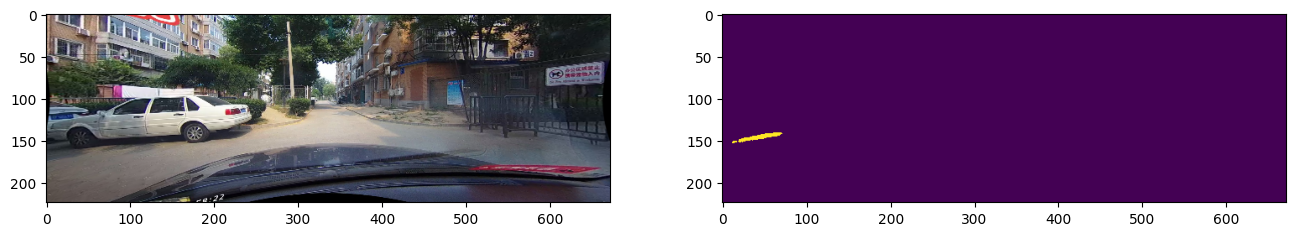

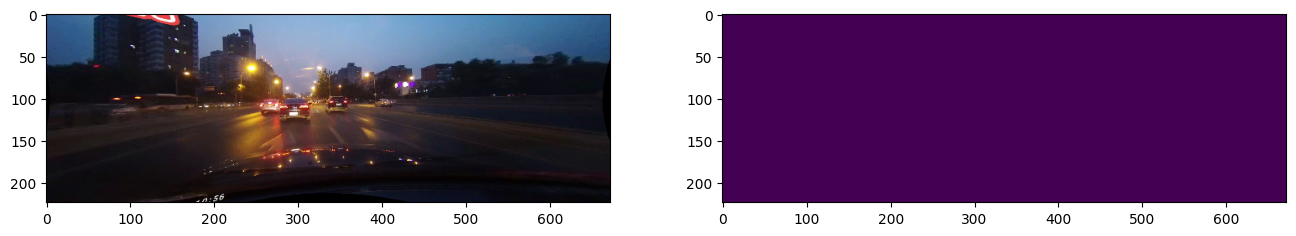

In [53]:
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # image follows (C, H, W) -> (H, W, C) ordering
    image = image.permute(1,2,0)
    image[:, :, 0] = image[:, :, 0] * std[0] + mean[0]
    image[:, :, 1] = image[:, :, 1] * std[1] + mean[1]
    image[:, :, 2] = image[:, :, 2] * std[2] + mean[2]
    return image

def denormalize_255(image):
    # image follows (C, H, W) -> (H, W, C) ordering
    image = image.permute(1,2,0)
    image = image * 255
    return image.int()

val_transforms = A.Compose([
    A.Resize(224, 672),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), normalization='standard', p=1.0),
    ToTensorV2(p=1.0)
])

test_transforms = A.Compose([
    A.Resize(224, 672),
    ToTensorV2()
])

def apply_transforms(image, transforms):
    transformed = transforms(image=image)
    transformed_img = transformed['image']
    return transformed_img

def visualize_mask(paths, model, vis_counts, transforms, device='cpu'):
    
    np.random.shuffle(paths) # random shuffling paths
    
    model = model.to(device) # allocate device to model
    model = model.eval() # evaluation mode
    
    counts = 0 # count number of visualization
    for path in paths:
        img = Image.open(path)
        img = img.convert('RGB') # convert to RGB (H, W, C) format
        
        img = np.array(img)
        # img = img.astype(np.float32) # normalize image by 255
        
        img = apply_transforms(image=img, transforms=transforms)
        img = img/255.
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(denormalize_255(img))
        
        img = img.unsqueeze(0)
        img = img.to(device)
        fmask = model(img)
        vis_img = fmask.argmax(dim=1)        
        vis_img = vis_img.permute(1, 2, 0)
        vis_img = vis_img.detach().cpu().numpy()
        
        plt.subplot(1, 2, 2)
        plt.imshow(vis_img)
        counts += 1
        if counts >= vis_counts:
            break

# visualize_mask(test_x, convnext_unet, 5, val_transforms, 'cpu')
visualize_mask(test_x, convnext_unet, 5, test_transforms, 'cpu')